# Carregamento do DataSet

In [1]:
%reload_ext autoreload
%autoreload 2

from variables import filenames, features, target
from load_dataset import load
from pre_processing import apply
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = load(filenames)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


# Preprocessamento

## Substituindo valores faltantes pela media

In [3]:
apply(df)

Quantidade de valores alterados:  3128


# Analise do Dataset

In [4]:
df.columns = df.columns.str.strip()
select_colums = ["Destination Port", "Total Fwd Packets", "Total Backward Packets", "Total Length of Fwd Packets", "Total Length of Bwd Packets", "Flow Duration", "Flow Packets/s", "Flow Bytes/s", "Down/Up Ratio", "Label"]
df = df[select_colums]
df.head()

,Destination Port,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Flow Duration,Flow Packets/s,Flow Bytes/s,Down/Up Ratio,Label
0,54865,2,0,12,0,3,666666.66670,4.000000e+06,0,BENIGN
1,55054,1,1,6,6,109,18348.62385,1.100917e+05,1,BENIGN
2,55055,1,1,6,6,52,38461.53846,2.307692e+05,1,BENIGN
3,46236,1,1,6,6,34,58823.52941,3.529412e+05,1,BENIGN
4,54863,2,0,12,0,3,666666.66670,4.000000e+06,0,BENIGN


In [5]:
df["Class"] = (df["Label"] != "BENIGN").astype(int)
df.drop(["Label"], axis=1 ,inplace=True)
df.head()

,Destination Port,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Flow Duration,Flow Packets/s,Flow Bytes/s,Down/Up Ratio,Class
0,54865,2,0,12,0,3,666666.66670,4.000000e+06,0,0
1,55054,1,1,6,6,109,18348.62385,1.100917e+05,1,0
2,55055,1,1,6,6,52,38461.53846,2.307692e+05,1,0
3,46236,1,1,6,6,34,58823.52941,3.529412e+05,1,0
4,54863,2,0,12,0,3,666666.66670,4.000000e+06,0,0


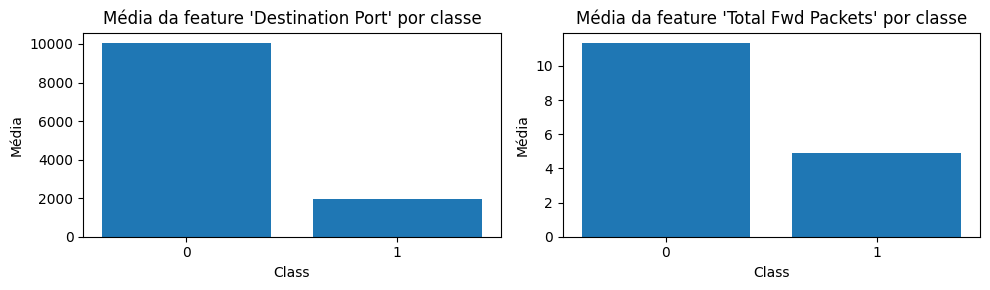

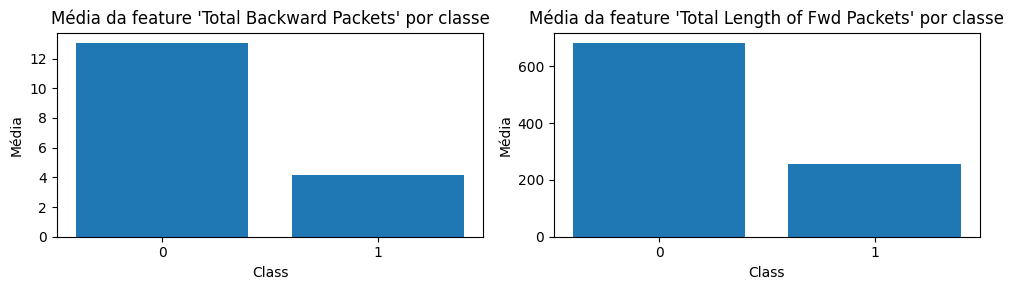

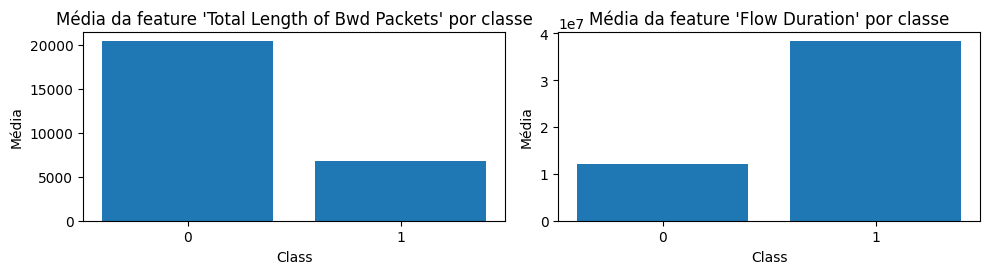

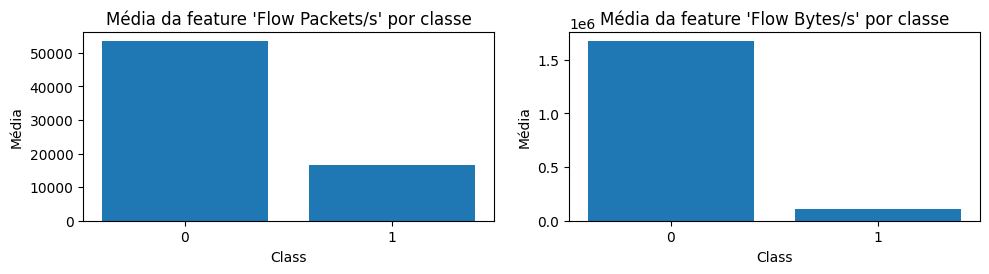

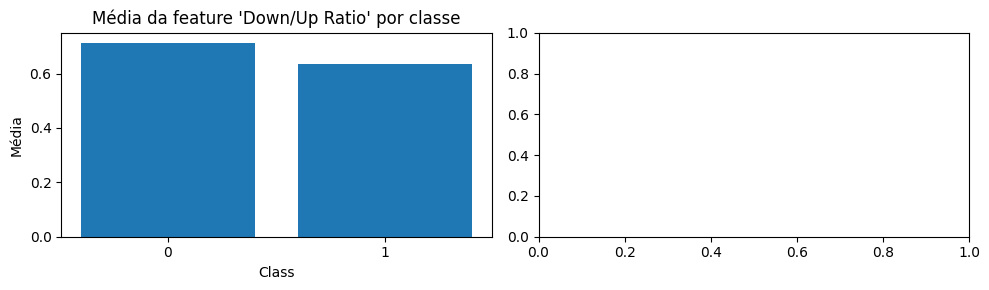

In [6]:

medias = df.groupby("Class").mean(numeric_only=True)
cols = medias.columns
n = len(cols)

for i in range(0, n, 2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    for j in range(2):
        if i + j < n:
            axs[j].bar(medias.index.astype(str), medias[cols[i + j]])
            axs[j].set_title(f"Média da feature '{cols[i + j]}' por classe")
            axs[j].set_xlabel("Class")
            axs[j].set_ylabel("Média")
    plt.tight_layout()
    plt.show()

## Balanceamento

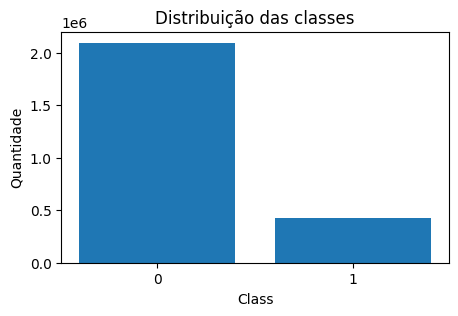

In [7]:
def plot_class_distribution(df, class_col="Class"):
    counts = df[class_col].value_counts().sort_index()
    plt.figure(figsize=(5,3))
    plt.bar(counts.index.astype(str), counts.values)
    plt.title("Distribuição das classes")
    plt.xlabel("Class")
    plt.ylabel("Quantidade")
    plt.show()
plot_class_distribution(df)

In [8]:
df[df["Class"] == 1].shape

(425878, 10)

In [9]:
classe_0 = df[df["Class"] == 0]
classe_1 = df[df["Class"] == 1]


min_count = min(len(classe_0), len(classe_1))

# Faz o undersample da classe maior
classe_0_sample = classe_0.sample(n=min_count, random_state=42)
classe_1_sample = classe_1.sample(n=min_count, random_state=42)

# Junta as duas classes
df_undersampled = pd.concat([classe_0_sample, classe_1_sample])

# Embaralha o resultado
df_undersampled = df_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

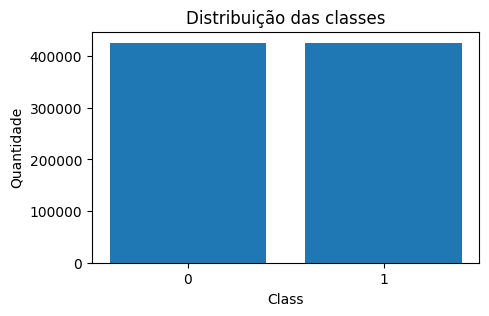

In [10]:
plot_class_distribution(df_undersampled)

# Treinamento

In [23]:
X = df_undersampled.iloc[:, :8]
y = df_undersampled["Class"]

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
class VerboseRandomForest(RandomForestClassifier):
    def fit(self, X, y, sample_weight=None):
        print(f"Iniciando treinamento com {self.n_estimators} árvores...")
        start = time.time()
        for i in tqdm(range(self.n_estimators), desc="Treinando árvores"):
            self.set_params(warm_start=True, n_estimators=i+1)
            super().fit(X, y, sample_weight)
        end = time.time()
        print(f"Treinamento concluído em {end - start:.2f} segundos")
        return self

In [28]:
randomForest1 = RandomForestClassifier(random_state=42, n_estimators=100, warm_start=True)
start = time.time()
randomForest1.fit(X_train_scaled, y_train)
end = time.time()
print(f"Treinamento concluído em {end - start:.2f} segundos")

Treinamento concluído em 55.58 segundos


In [29]:
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import time

class VerboseRandomForest(RandomForestClassifier):
    def fit(self, X, y, sample_weight=None):
        print(f"Iniciando treinamento com {self.n_estimators} árvores...")
        start = time.time()
        for i in tqdm(range(self.n_estimators), desc="Treinando árvores"):
            self.set_params(warm_start=True, n_estimators=i+1)
            super().fit(X, y, sample_weight)
        end = time.time()
        print(f"Treinamento concluído em {end - start:.2f} segundos")
        return self
    
randomForest2 = VerboseRandomForest(random_state=42, n_estimators=100, warm_start=True)
randomForest2.fit(X_train_scaled, y_train)


Iniciando treinamento com 100 árvores...


Treinando árvores: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]

Treinamento concluído em 58.56 segundos


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [36]:
import joblib

# Salvar o modelo treinado
joblib.dump(randomForest1, "modelo/random_forest_model.joblib")

# Salvar o scaler
joblib.dump(scaler, "modelo/minmax_scaler.joblib")

['modelo/minmax_scaler.joblib']

In [22]:
df_undersampled.head()

,Destination Port,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Flow Duration,Flow Packets/s,Flow Bytes/s,Down/Up Ratio,Class
0,37,2,2,4,12,23,173913.043500,6.956522e+05,1,0
1,53,2,2,72,200,217,18433.179720,1.253456e+06,1,0
2,80,4,0,24,0,1890958,2.115330,1.269198e+01,0,1
3,8873,1,1,0,6,39,51282.051280,1.538462e+05,1,1
4,123,1,1,48,48,35977,55.591072,2.668371e+03,1,0


In [31]:
y_predict = randomForest1.predict(X_test_scaled)

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

def show_classification_metrics(y_true, y_pred):
    print("Acurácia:", accuracy_score(y_true, y_pred))
    print("Precisão:", precision_score(y_true, y_pred, average='binary'))
    print("Recall:", recall_score(y_true, y_pred, average='binary'))
    print("F1 Score:", f1_score(y_true, y_pred, average='binary'))
    print("\nRelatório de Classificação:")
    print(classification_report(y_true, y_pred))

    # Matriz de confusão gráfica
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.show()

def plot_roc_auc(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR (False Positive Rate)')
    plt.ylabel('TPR (True Positive Rate)')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()
    print(f'AUC: {auc:.4f}')

Acurácia: 0.9939302150840612
Precisão: 0.9942900110440116
Recall: 0.993566262797032
F1 Score: 0.9939280051676552

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     85176
           1       0.99      0.99      0.99     85176

    accuracy                           0.99    170352
   macro avg       0.99      0.99      0.99    170352
weighted avg       0.99      0.99      0.99    170352



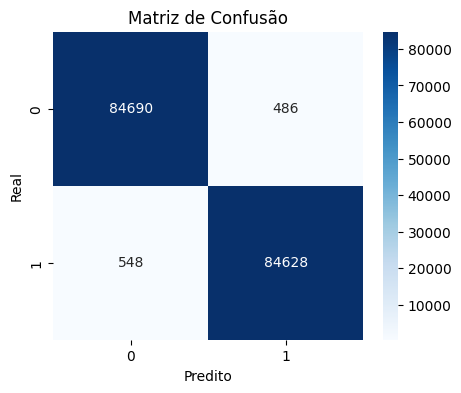

In [34]:
show_classification_metrics(y_test, y_predict)

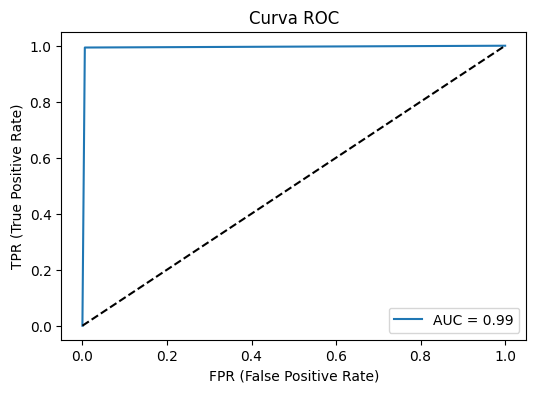

AUC: 0.9939


In [35]:
plot_roc_auc(y_test, y_predict)